In [50]:
import pandas as pd 
import numpy as np 
import sys 
# Load libraries
import sys
from pathlib import Path
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
sustain_path = '/Users/mlin2/Desktop/RabLab/eoad_sustain_ml/pySuStaIn'
parent_path = str(Path(sustain_path).parent)
if parent_path not in sys.path:
        sys.path.insert(0, parent_path)
import pySuStaIn
import os  

# data reading

In [51]:
tdata = pd.read_csv('ucsf_t1dat_baseline.csv')
print(tdata.columns)
tdata.subtype.value_counts()

Index(['subj', 'PIDN', 'APOE', 'DigitFW', 'ucsf_dx', 'CDRSUM', 'MMSETot',
       'CVLT', 'BID', 'clin_severity', 'Centiloid', 'cogpet_datediff', 'Educ',
       'SemanticFluency', 'tiv_pib', 'DCDate', 'DigitBW', 'dx',
       'cortical_ftp_suvr', 'taudate', 'pib_cortex', 'tiv_ftp',
       'cortical_summary_PiB_SUVR', 'age', 'sex', 'metaROI_FTP_SUVR',
       'amyloid_path', 'tau_path', 'BensonCopy', 'amyloid_date', 'ftp_cortex',
       'Trails', 'BensonDelay', 'mri_cortex', 'APOEStatus', 'APOEGenotype',
       'L_MTL', 'R_MTL', 'L_temporal', 'R_temporal', 'L_frontal', 'R_frontal',
       'L_occipital', 'R_occipital', 'L_parietal', 'R_parietal', '2', '2s',
       '2_subtype_prob', '2_stage_prob', '3', '3s', '3_subtype_prob',
       '3_stage_prob', '4', '4s', '4_subtype_prob', '4_stage_prob', '5', '5s',
       '5_subtype_prob', '5_stage_prob', '6', '6s', '6_subtype_prob',
       '6_stage_prob', 'subtype', 'stage', 'subtype_prob'],
      dtype='object')


subtype
2    25
3    24
1    16
Name: count, dtype: int64

In [52]:
'subj', 'PIDN','ucsf_dx', 'CDRSUM', 'subtype', 'stage','taudate','DCDate',

('subj', 'PIDN', 'ucsf_dx', 'CDRSUM', 'subtype', 'stage', 'taudate', 'DCDate')

In [53]:
long = pd.read_excel("07_02_2025_mac_cdr_results.xlsx")
long.columns

Index(['PIDN', 'DCDate', 'AgeAtDC', 'InstrID', 'CDR Box'], dtype='object')

In [54]:
long.AgeAtDC.describe()

count    159.000000
mean      57.817610
std        5.022551
min       45.000000
25%       55.000000
50%       58.000000
75%       62.000000
max       71.000000
Name: AgeAtDC, dtype: float64

In [55]:
long.DCDate.describe()

count                              159
mean     2016-12-24 20:49:48.679245312
min                2013-09-13 00:00:00
25%                2015-11-17 00:00:00
50%                2016-10-11 00:00:00
75%                2017-11-12 00:00:00
max                2022-09-14 00:00:00
Name: DCDate, dtype: object

In [56]:
long["CDR Box"].describe()

count    159.000000
mean       4.188679
std        3.524184
min       -5.000000
25%        3.000000
50%        4.500000
75%        5.000000
max       14.000000
Name: CDR Box, dtype: float64

In [57]:
# filter out negative 
long = long[long["CDR Box"] >= 0]
# filter by ID
long = long[long.PIDN.isin(tdata.PIDN.tolist())]
bl = tdata[['subj', 'PIDN','ucsf_dx', 'CDRSUM', 'subtype', 'stage','taudate','DCDate','age', 'sex','Educ','Centiloid']]
bl.columns = ['subj', 'PIDN','baseline_ucsf_dx', 'baseline_CDRSUM', 'baseline_subtype', 'baseline_stage','baseline_taudate','baseline_DCDate','baseline_age','baseline_sex','baseline_Educ','baseline_Centiloid']
long.columns = ['PIDN', 'DCDate', 'AgeAtDC', 'InstrID', 'CDRSUM']

In [58]:
print(long.columns)

Index(['PIDN', 'DCDate', 'AgeAtDC', 'InstrID', 'CDRSUM'], dtype='object')


In [59]:
print(len(long.PIDN.unique()))
print(len(long))
merged = pd.merge(long, bl, on='PIDN', how='left')
print(len(merged.PIDN.unique()))
print(len(merged))

65
150
65
150


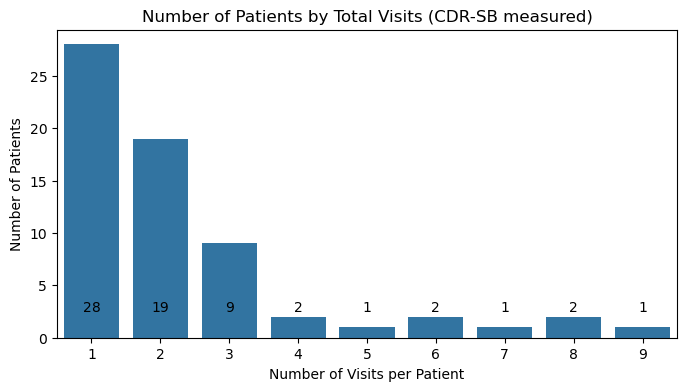

In [60]:
# Count number of visits per patient (PIDN) where CDRSUM is not null
visit_counts = merged.groupby('PIDN')['CDRSUM'].count()

# Plot using seaborn as a bar chart, with count annotations at the bottom
plt.figure(figsize=(8,4))
ax = sns.countplot(x=visit_counts)
plt.xlabel('Number of Visits per Patient')
plt.ylabel('Number of Patients')
plt.title('Number of Patients by Total Visits (CDR-SB measured)')

# Annotate each bar with the count at the bottom
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., 2),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0,2), textcoords='offset points')

plt.show()


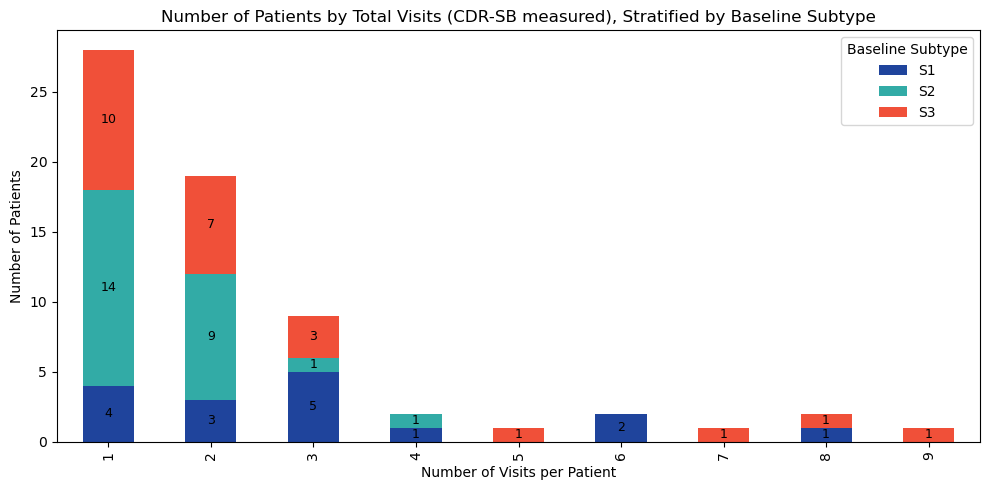

In [61]:
# Count number of patients by visit_count and baseline_subtype
visit_counts_df = merged.groupby(['PIDN', 'baseline_subtype']).size().reset_index(name='visit_count')
ct = visit_counts_df.groupby(['visit_count', 'baseline_subtype']).size().unstack(fill_value=0)
ct.index.name = 'visit_count'
ct.columns.name = 'baseline_subtype'
ax = ct.plot(kind='bar', stacked=True, figsize=(10,5), colormap='tab20')
plt.xlabel('Number of Visits per Patient')
plt.ylabel('Number of Patients')
plt.title('Number of Patients by Total Visits (CDR-SB measured), Stratified by Baseline Subtype')
plt.legend(title='Baseline Subtype')
plt.tight_layout()

# Annotate each segment with the count, skip zeros
for c in ax.containers:
    labels = [f'{int(v)}' if v > 0 else '' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=9)

# Set custom colors for subtype 1, 2, 3
colors = ["#1f449c", "#32ABA6", "#f05039"]
for i, bar in enumerate(ax.patches):
    subtype_idx = i // len(ct)
    bar.set_facecolor(colors[subtype_idx])

# Fix legend to match custom colors and subtype order
handles, labels = ax.get_legend_handles_labels()
new_labels = ['S1', 'S2', 'S3']
ax.legend(handles, new_labels, title='Baseline Subtype')

plt.show()


In [62]:
visit_counts[visit_counts > 4]

PIDN
18344    6
18551    9
19022    5
19204    6
20734    8
20757    7
21556    8
Name: CDRSUM, dtype: int64

In [63]:
long[long.PIDN==18551]

,PIDN,DCDate,AgeAtDC,InstrID,CDRSUM
29,18551,2015-07-27,60,406595,3.5
30,18551,2016-01-07,60,382270,4.5
31,18551,2016-04-01,60,403877,4.5
32,18551,2016-04-29,60,408377,5.0
33,18551,2016-05-27,60,411519,6.0
34,18551,2016-06-24,61,412124,5.0
35,18551,2016-07-11,61,413653,4.0
36,18551,2017-07-20,62,468423,5.0
37,18551,2018-07-10,63,497140,6.0


In [64]:
# Sort merged by PIDN and DCDate, then calculate followup_interval
merged_sorted = merged.sort_values(['PIDN', 'DCDate']).copy()
merged_sorted['followup_interval'] = merged_sorted.groupby('PIDN')['DCDate'].diff().dt.days
# Only include participants with at least two visits
visit_counts = merged_sorted.groupby('PIDN')['CDRSUM'].count()
pids_with_followup = visit_counts[visit_counts >= 2].index

# Filter merged_sorted for those with at least two visits and non-null followup_interval
followup_df = merged_sorted[
    (merged_sorted['PIDN'].isin(pids_with_followup)) &
    (merged_sorted['followup_interval'].notnull())
]

n_subjects_with_followup = followup_df['PIDN'].nunique()
overall_mean_yr = followup_df['followup_interval'].mean() / 365.25
overall_std_yr = followup_df['followup_interval'].std() / 365.25

print(f"There are {n_subjects_with_followup} participants with at least two visits.")
print(f"The overall mean follow-up interval for these participants is {overall_mean_yr:.2f} years (SD = {overall_std_yr:.2f} years).")

by_subtype_yr = followup_df.groupby('baseline_subtype')['followup_interval'].agg(['mean', 'std']) / 365.25
for subtype, row in by_subtype_yr.iterrows():
    print(f"For subtype {subtype}, the mean follow-up interval is {row['mean']:.2f} years (SD = {row['std']:.2f} years).")


There are 37 participants with at least two visits.
The overall mean follow-up interval for these participants is 0.85 years (SD = 0.83 years).
For subtype 1, the mean follow-up interval is 0.75 years (SD = 0.65 years).
For subtype 2, the mean follow-up interval is 1.43 years (SD = 0.83 years).
For subtype 3, the mean follow-up interval is 0.72 years (SD = 0.89 years).


In [65]:
merged.columns

Index(['PIDN', 'DCDate', 'AgeAtDC', 'InstrID', 'CDRSUM', 'subj',
       'baseline_ucsf_dx', 'baseline_CDRSUM', 'baseline_subtype',
       'baseline_stage', 'baseline_taudate', 'baseline_DCDate', 'baseline_age',
       'baseline_sex', 'baseline_Educ', 'baseline_Centiloid'],
      dtype='object')

In [66]:
# Filter for patients with at least two CDRSUM records
df_save = merged[
    merged['PIDN'].isin(pids_with_followup)
][['PIDN', 'baseline_subtype', 'DCDate', 'CDRSUM','baseline_sex','baseline_Educ','baseline_Centiloid','baseline_age']].copy()


In [68]:
# Calculate the earliest DCDate per PIDN
first_dates = df_save.groupby('PIDN')['DCDate'].min()

# Calculate diff_yr as years since first DCDate for each record
df_save['diff_yr'] = (df_save['DCDate'] - df_save['PIDN'].map(first_dates)).dt.days / 365.25

# Add visit_ct column: visit number per PIDN, baseline is 1
df_save['visit_ct'] = df_save.sort_values(['PIDN', 'DCDate']).groupby('PIDN').cumcount() + 1

# Summary statistics of the intervals between visits (excluding 0 intervals)
intervals = []
for pid, group in df_save.sort_values(['PIDN', 'DCDate']).groupby('PIDN'):
    diffs = group['DCDate'].diff().dt.days.dropna() / 365.25
    intervals.extend(diffs.values)

intervals = np.array(intervals)
print(f"Mean interval between visits: {intervals.mean():.2f} years")
print(f"SD of interval between visits: {intervals.std():.2f} years")
print(f"Min interval: {intervals.min():.2f} years")
print(f"Max interval: {intervals.max():.2f} years")
print(f"Median interval: {np.median(intervals):.2f} years")

df_save.head()

Mean interval between visits: 0.85 years
SD of interval between visits: 0.82 years
Min interval: 0.00 years
Max interval: 3.88 years
Median interval: 0.97 years


,PIDN,baseline_subtype,DCDate,CDRSUM,baseline_sex,baseline_Educ,baseline_Centiloid,baseline_age,diff_yr,visit_ct
1,16407,1,2014-05-12,4.5,Female,16.0,109.705378,62,0.000000,1
2,16407,1,2015-06-02,5.0,Female,16.0,109.705378,62,1.056810,2
3,16407,1,2016-12-07,12.0,Female,16.0,109.705378,62,2.573580,3
4,16417,3,2013-12-09,5.0,Male,15.0,83.591531,57,0.000000,1
5,16417,3,2015-01-30,8.0,Male,15.0,83.591531,57,1.141684,2


In [72]:
df_check = df_save[df_save.diff_yr==0]
df_check[df_check.visit_ct==2]

,PIDN,baseline_subtype,DCDate,CDRSUM,baseline_sex,baseline_Educ,baseline_Centiloid,baseline_age,diff_yr,visit_ct
125,24581,3,2017-06-22,0.5,Female,13.0,100.79648,62,0.0,2


In [74]:
long[long.PIDN==24581]

,PIDN,DCDate,AgeAtDC,InstrID,CDRSUM
133,24581,2017-06-22,62,455094,0.5
134,24581,2017-06-22,62,491981,0.5


In [ ]:
# drop this patient
df_save = df_save[df_save.PIDN != 24581]


In [76]:

# Save to CSV
df_save.to_csv('ucsf_cdrsb_long.csv', index=False)
df_save.head()

,PIDN,baseline_subtype,DCDate,CDRSUM,baseline_sex,baseline_Educ,baseline_Centiloid,baseline_age,diff_yr,visit_ct
1,16407,1,2014-05-12,4.5,Female,16.0,109.705378,62,0.000000,1
2,16407,1,2015-06-02,5.0,Female,16.0,109.705378,62,1.056810,2
3,16407,1,2016-12-07,12.0,Female,16.0,109.705378,62,2.573580,3
4,16417,3,2013-12-09,5.0,Male,15.0,83.591531,57,0.000000,1
5,16417,3,2015-01-30,8.0,Male,15.0,83.591531,57,1.141684,2
